# Parameter Estimation

## Model dynamics

In [109]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [110]:
def HH_dynamics(state):
    """
    The variable 'state' is the current state of the system
    """

    import numpy as np

    V, n, h, B, gB, EB, VBth, SB, tauB, Icur = state

    F = np.zeros_like(state)

    # Set parameters
    mInf = 1 / (1 + np.exp((-V - 34.5) / 10))  # HH options
    nInf = 1 / (1 + np.exp((-V - 29.5) / 10))
    hInf = 1 / (1 + np.exp((V + 59.4) / 10.7))
    tauN = 0.25 + 4.35 * np.exp(-abs(V + 10) / 10)
    tauH = 0.15 + 1.15 / (1 + np.exp((V + 33.5) / 15))
    BInf = 1. / (1 + np.exp(-(V - VBth) / SB))
#     tauB = tauB
    C = 0.9
    EK = -95
    ENa = 50
    EL = -70
    gNa = 100
    gK = 7
    gL = 0.25

    # Calculate changes
    Vdot = (Icur -  # drive current
            gK * n**4 * (V - EK) -  # Potassium
            gNa * mInf ** 3 * h * (V - ENa) -  # Sodium
            gB * B * (V - EB) -  # mystery
            gL * (V - EL)) / C  # Leak

    ndot = (nInf - n) / tauN  # F2(n)

    hdot = (hInf - h) / tauH  # F3(h)

    Bdot = (BInf - B) / tauB  # F4(B)

    F[:4] = [Vdot, ndot, hdot, Bdot]  # state change
    
    return F


## Running a simulation

In [111]:
noiseStd = [1, 0, 0, 0]  # Measurment noise
delta = 0.01  # integration step [ms]
Vth = 30  # count spikes when voltage goes above Vth

In [112]:
V = -70
n = 0.0147
h = 0.7497
B = 0.0326

gB = 3.5
EB = -74.8
VBth = -2.2
SB = 9.6
tauB = 64
I = -2.5

s0 = [V, n, h, B]
params = [gB, EB, VBth, SB, tauB, I]

In [113]:
# Run Sim
NUM_ALL = len(s0 + params)
TOTAL_TIME = int(1e3 / delta)  # time steps to simulate (ms * fs)
# TOTAL_TIME = 5
states = np.array(s0 + params)  # initial states

In [114]:
sim = np.zeros((TOTAL_TIME, NUM_ALL))  # to hold simulation results
while len(noiseStd) < states.shape[0]:
    noiseStd += [0]
noiseStd = np.array(noiseStd)

In [115]:
for t in range(TOTAL_TIME):
    dS = HH_dynamics(states)  # dynamics
    # updated states
    states += dS * delta + noiseStd * np.random.randn(np.size(states))
    temp = states[1:4,]
    temp[states[1:4,] > 1] = 1
    temp[states[1:4,] < 0] = 0
    sim[t] = states[:]

## Plotting the simulation

<IPython.core.display.Javascript object>


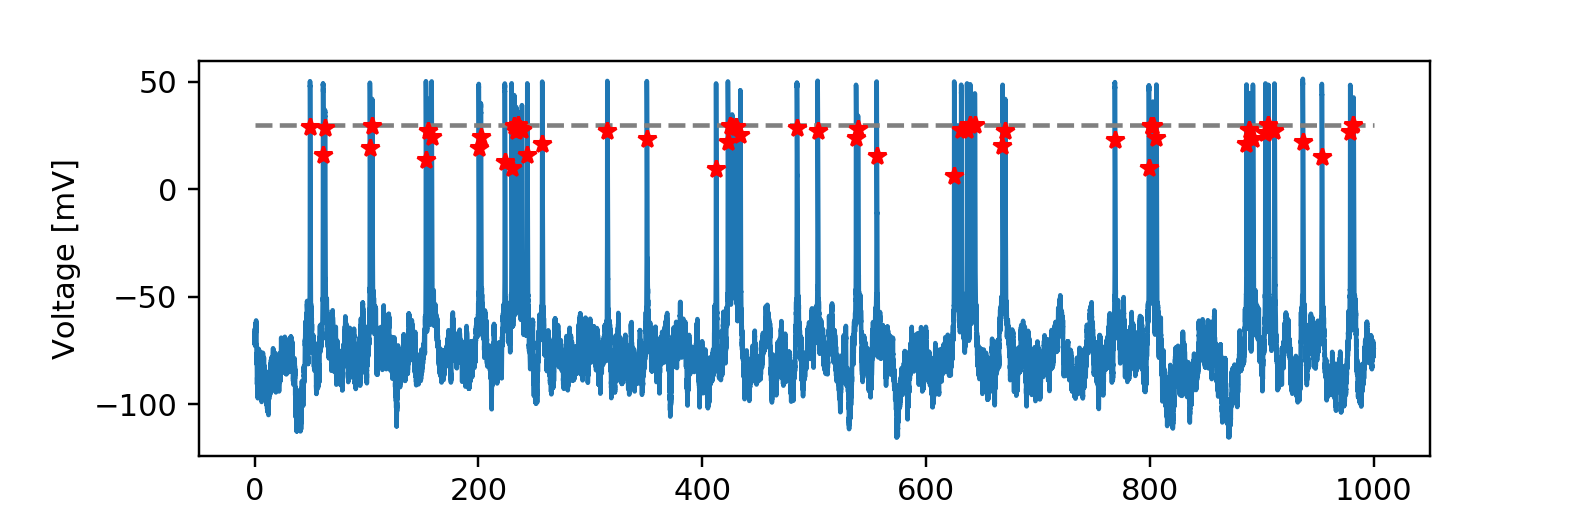

In [116]:
# Plot Results
# plt.subplot(8, 1, 2:7);
tt = np.array([i * delta for i in range(TOTAL_TIME)])
plt.plot(tt, sim[:, 0])
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [ms]')

plt.plot([0, delta * TOTAL_TIME], [Vth, Vth], '--', color='gray')

s1 = sim[:-1, 0] < Vth
s2 = sim[1:, 0] >= Vth
spikes = np.hstack((s1 & s2, False))
plt.plot(tt[spikes], sim[spikes, 0], 'r*')
